## Udacity Self-Driving Car Nanodegree

### Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


### Import Libraries

In [70]:
# imports

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from numpy import pi
import glob
from moviepy.editor import VideoFileClip

%matplotlib inline

#import pickle
#from ipywidgets import interact, interactive, fixed

#from IPython.display import HTML

## Camera Calibration

There are 20 calibration images and they are 720 x 1280 pixels (a couple of them are 721 x 1281).  First we iterate through the chessboard images and in each case try to find the inner corners.  Draw the chessboard with the corners.

In [71]:
def calibrate_camera(nx=9, ny=6):
    # the number of chessboard corners
    nx = 9
    ny = 6

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # calculate the object points (for an undistorted chessboard)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    files = glob.glob("camera_cal/calibration*.jpg")

    fig, axs = plt.subplots(5,4, figsize=(16, 11))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()

    # iterate through the images
    for idx, file in enumerate(files):
        img = mpimg.imread(file)
        # Convert from BGR to grayscale to use for corner detection.
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # Do this only if we can detect ALL nx by ny of the corners
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)   

        axs[idx].imshow(img)

    # caculate the camera matrix (mtx) and the distortion coefficients (dist)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

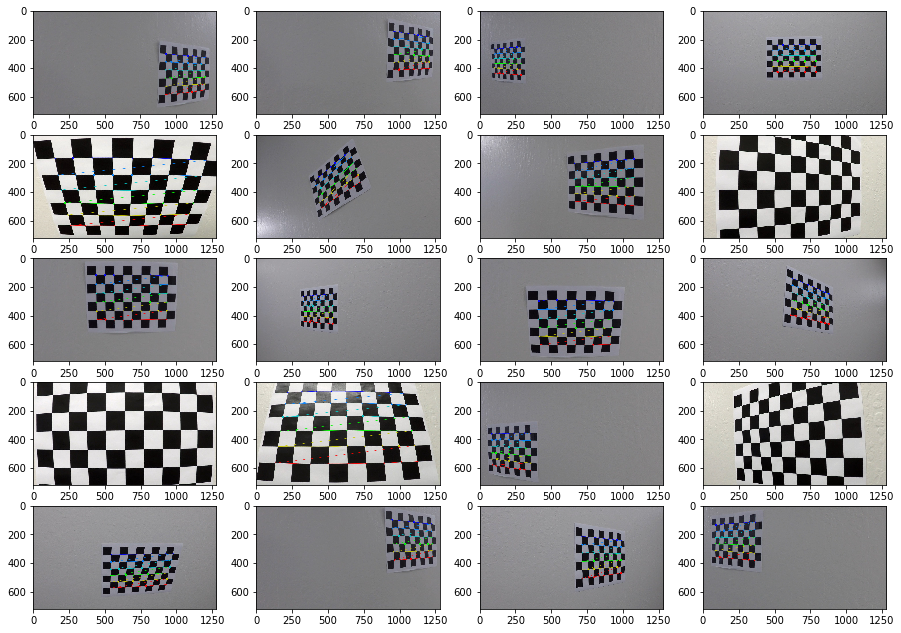

In [72]:
mtx, dist = calibrate_camera()

Now that we have calibrated the camera, let's try undistorting some examples using the following function.

In [73]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [74]:
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

Testing the camera calibration by undistorting the chessboard examples

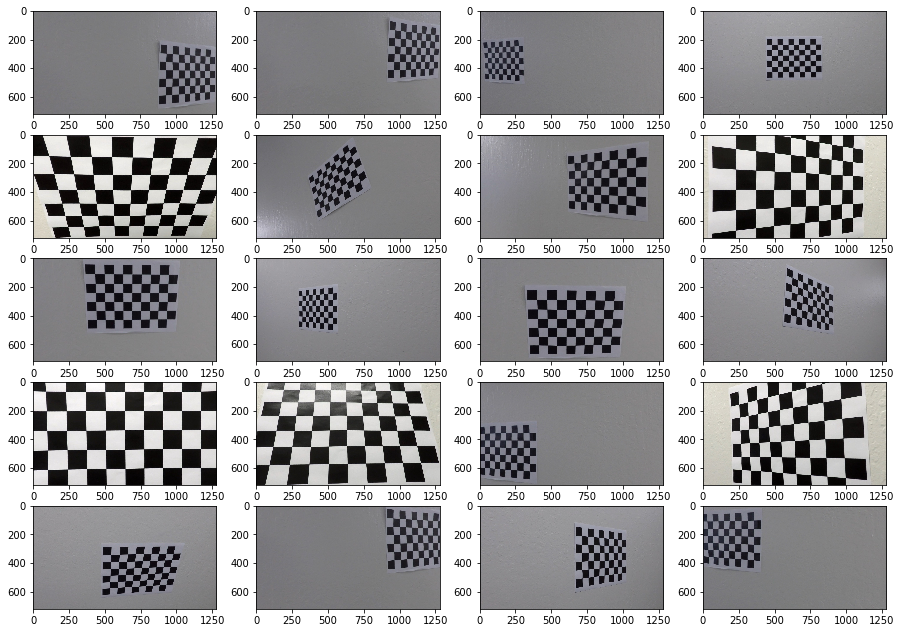

In [75]:
fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
files = glob.glob("camera_cal/calibration*.jpg")

# iterate through the images
for idx, file in enumerate(files):
    img = mpimg.imread(file)
    undist = undistort(img, mtx, dist)
    axs[idx].imshow(undist)

### Original Test Images

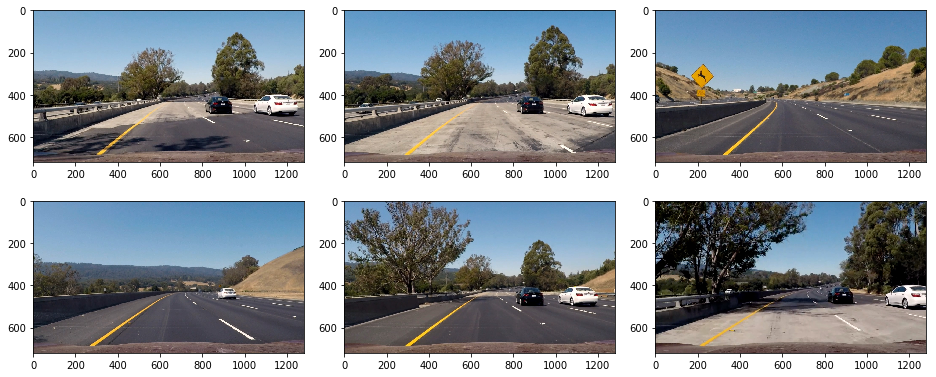

In [76]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()
files = glob.glob('test_images/test*.jpg')
#files = glob.glob('output_images/ProblemClip*.jpg')

# iterate through the images
for idx, file in enumerate(files): 
    img = mpimg.imread(file)
    axs[idx].imshow(img)

## Undistorted Test Images

Let's apply the undistortion to the test images

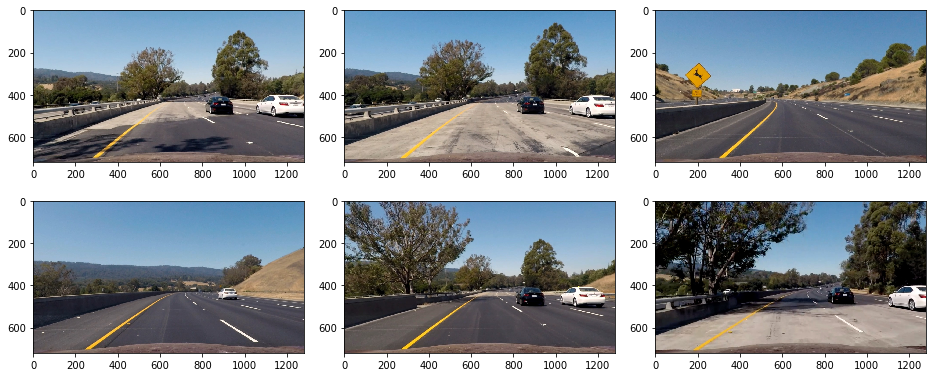

In [77]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()

# iterate through the images
for idx, file in enumerate(files):
    img = mpimg.imread(file)
    undist = undistort(img, mtx, dist)
    axs[idx].imshow(undist)

## Image Thresholding

### Gradient Thresholding Using the Sobel operator

In [78]:
def sobel_thresh(img, orient='x',  thresh=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return np.copy(sxbinary) 

In [79]:
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude 
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    
    # Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return np.copy(sxbinary) 

In [80]:
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return np.copy(binary_output) 

### X-Gradient Thresholding

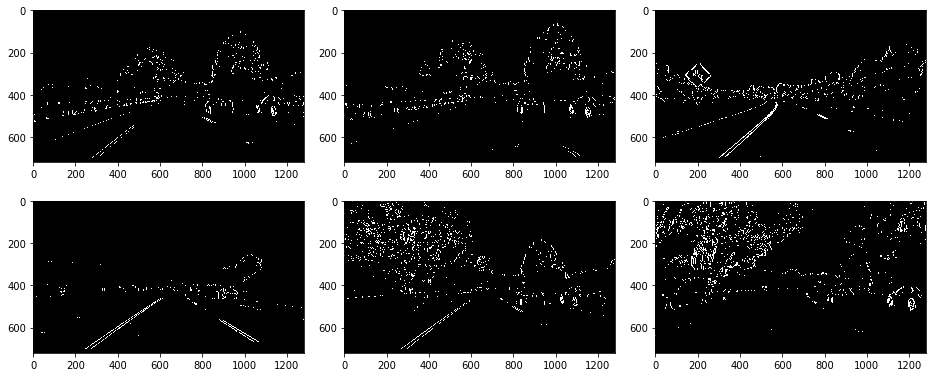

In [81]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()

# iterate through the images
for idx, file in enumerate(files):
    img = mpimg.imread(file)
    undist = undistort(img, mtx, dist)
    blurred = gaussian_blur(undist, 5)
    grad_x_thresh = sobel_thresh(blurred, 'x', (50, 255))
    axs[idx].imshow(grad_x_thresh,  cmap = 'gray')

### Y-Gradient Thresholding

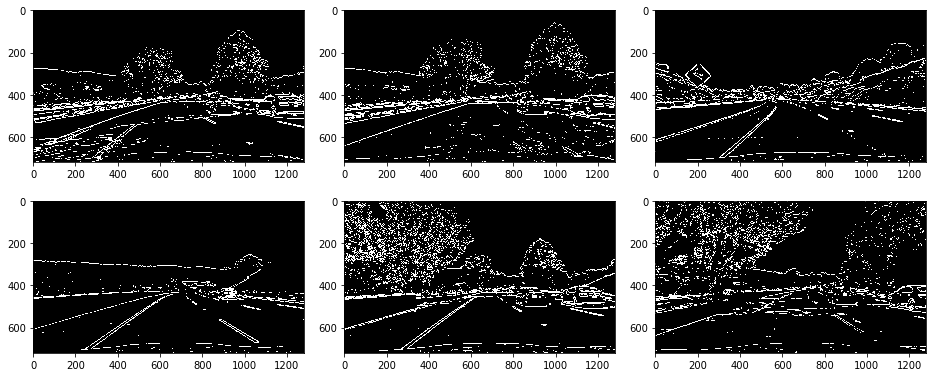

In [82]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()

# iterate through the images
for idx, file in enumerate(files):
    img = mpimg.imread(file)
    undist = undistort(img, mtx, dist)
    blurred = gaussian_blur(undist, 3)
    grad_y_thresh = sobel_thresh(blurred, 'y', (30, 250))
    axs[idx].imshow(grad_y_thresh,  cmap = 'gray')

### Gradient Magnitude Thresholding

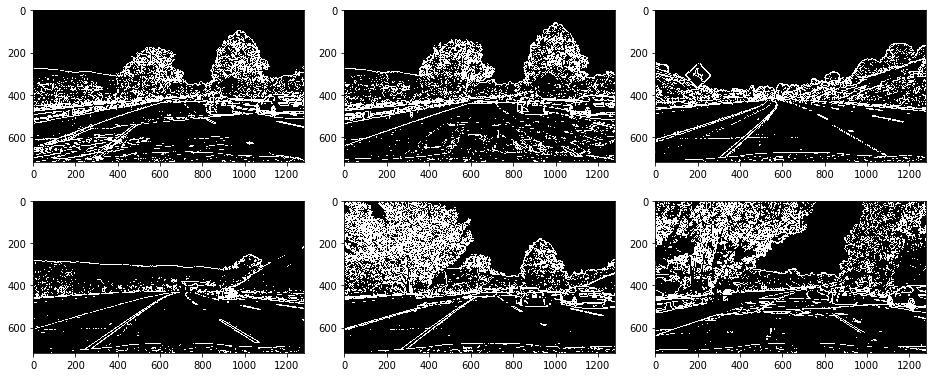

In [83]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()

# iterate through the images
for idx, file in enumerate(files):
    img = mpimg.imread(file)
    undist = undistort(img, mtx, dist)
    blurred = gaussian_blur(undist, 3)
    grad_mag_thresh = mag_thresh(blurred, 3, (20, 255))
    axs[idx].imshow(grad_mag_thresh,  cmap = 'gray')

### Gradient Direction Thresholding

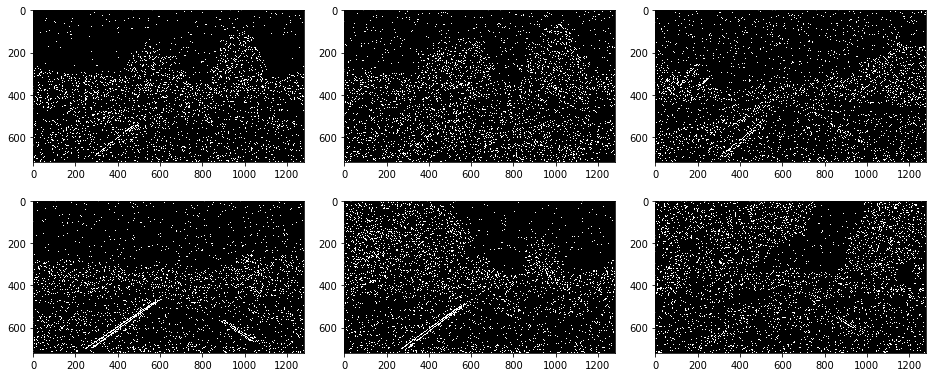

In [84]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()

# iterate through the images
for idx, file in enumerate(files):
    img = mpimg.imread(file)
    undist = undistort(img, mtx, dist)
    blurred = gaussian_blur(undist, 3)
    a = 0.95
    b = .1
    grad_dir_thresh = dir_thresh(blurred, 3, (a-b, a+b))
    axs[idx].imshow(grad_dir_thresh,  cmap = 'gray')

### Combining Sobel Thresholds

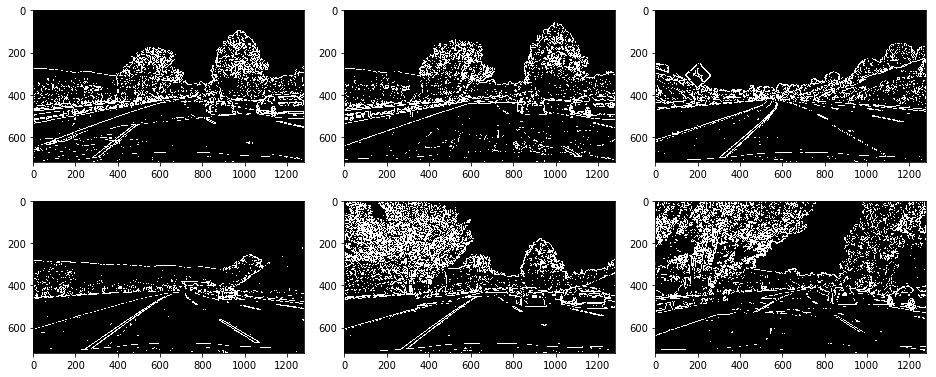

In [85]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()

# iterate through the images
for idx, file in enumerate(files):
    img = mpimg.imread(file)
    undist = undistort(img, mtx, dist)
    blurred = gaussian_blur(undist, 3)
    
    grad_x_thresh = sobel_thresh(blurred, 'x', (20, 255))
    grad_y_thresh = sobel_thresh(blurred, 'y', (40, 150))
    grad_mag_thresh = mag_thresh(blurred, 3, (20, 255))
    grad_dir_thresh = dir_thresh(blurred, 3, (0.85, 1.05))
    
    combined = np.zeros_like(grad_x_thresh)
    combination = ((grad_mag_thresh == 1) & (grad_dir_thresh == 1)) | (grad_x_thresh == 1) | (grad_y_thresh == 1)
    combined[combination] = 1
    
    axs[idx].imshow(combined,  cmap = 'gray')

### Color Thresholding

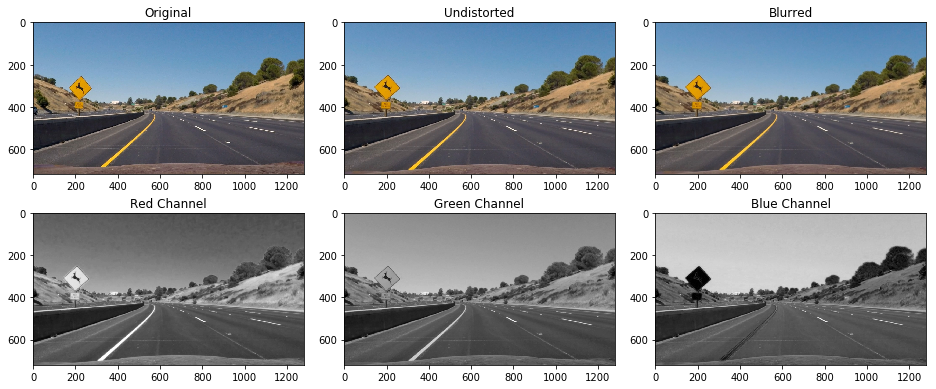

In [86]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()
filename = 'test_images/test2.jpg'
#filename = 'output_images/ProblemClip1.jpg'

img = mpimg.imread(filename)
undist = undistort(img, mtx, dist)
blurred = gaussian_blur(undist, 3)

# Color Space is RGB due to matplotlib's imread method
R = blurred[:,:,0]
G = blurred[:,:,1]
B = blurred[:,:,2]

axs[0].imshow(img)
axs[1].imshow(undist)
axs[2].imshow(blurred)
axs[3].imshow(R, cmap='gray')
axs[4].imshow(G, cmap='gray')
axs[5].imshow(B, cmap='gray')

for i, title in enumerate(['Original', 'Undistorted', 'Blurred', 'Red Channel', 'Green Channel', 'Blue Channel']):
    axs[i].set_title(title, fontsize=12)

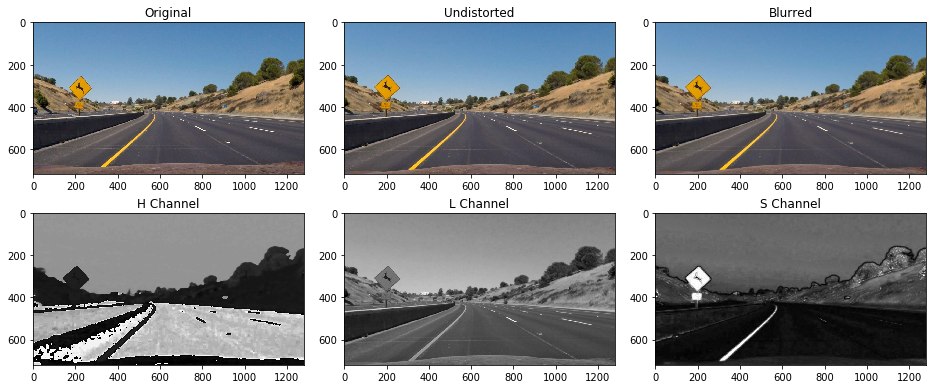

In [87]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()

img = mpimg.imread(filename)
undist = undistort(img, mtx, dist)
blurred = gaussian_blur(undist, 3)

hls = cv2.cvtColor(blurred, cv2.COLOR_RGB2HLS)

# Color Space is RGB due to matplotlib's imread method
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

axs[0].imshow(img)
axs[1].imshow(undist)
axs[2].imshow(blurred)
axs[3].imshow(H, cmap='gray')
axs[4].imshow(L, cmap='gray')
axs[5].imshow(S, cmap='gray')

for i, title in enumerate(['Original', 'Undistorted', 'Blurred', 'H Channel', 'L Channel', 'S Channel']):
    axs[i].set_title(title, fontsize=12)

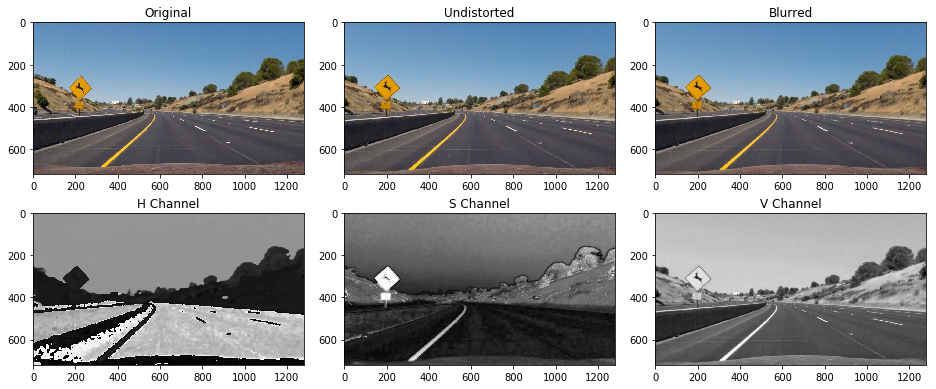

In [88]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()

img = mpimg.imread(filename)
undist = undistort(img, mtx, dist)
blurred = gaussian_blur(undist, 3)

hsv = cv2.cvtColor(blurred, cv2.COLOR_RGB2HSV)

# Color Space is RGB due to matplotlib's imread method
H = hsv[:,:,0]
S = hsv[:,:,1]
V = hsv[:,:,2]

axs[0].imshow(img)
axs[1].imshow(undist)
axs[2].imshow(blurred)
axs[3].imshow(H, cmap='gray')
axs[4].imshow(S, cmap='gray')
axs[5].imshow(V, cmap='gray')

for i, title in enumerate(['Original', 'Undistorted', 'Blurred', 'H Channel', 'S Channel', 'V Channel']):
    axs[i].set_title(title, fontsize=12)

#### CieLAB Color Space

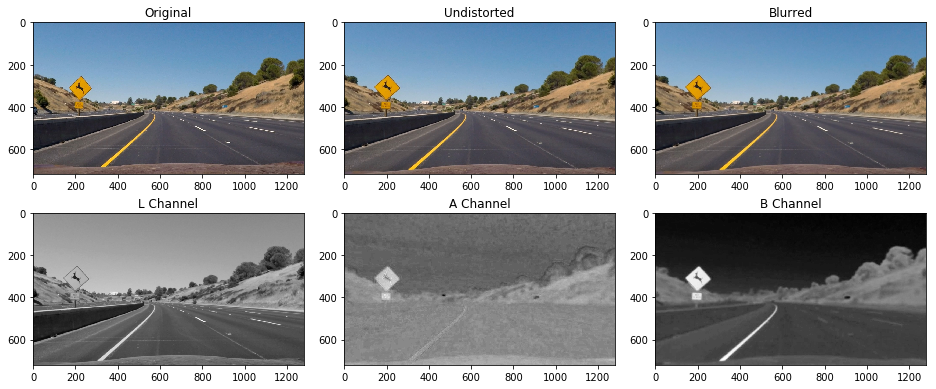

In [89]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()

img = mpimg.imread(filename)
undist = undistort(img, mtx, dist)
blurred = gaussian_blur(undist, 3)

lab = cv2.cvtColor(blurred, cv2.COLOR_RGB2Lab)

# Color Space is RGB due to matplotlib's imread method
L = lab[:,:,0]
A = lab[:,:,1]
B = lab[:,:,2]

axs[0].imshow(img)
axs[1].imshow(undist)
axs[2].imshow(blurred)
axs[3].imshow(L, cmap='gray')
axs[4].imshow(A, cmap='gray')
axs[5].imshow(B, cmap='gray')

for i, title in enumerate(['Original', 'Undistorted', 'Blurred', 'L Channel', 'A Channel', 'B Channel']):
    axs[i].set_title(title, fontsize=12)

#### CieLUV Color Space

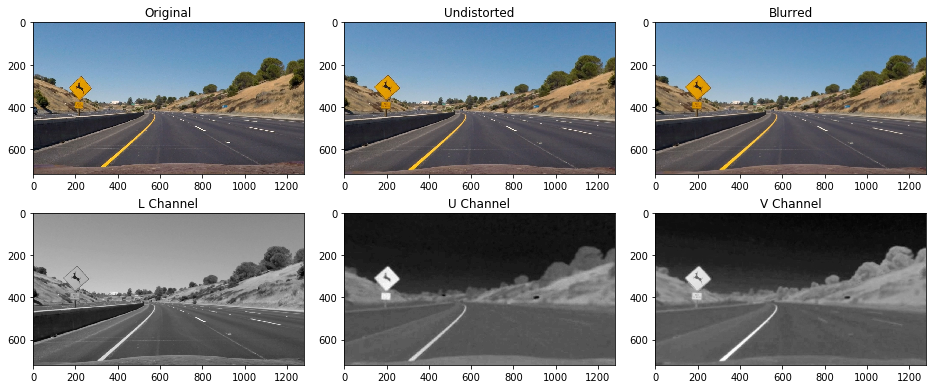

In [90]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()

img = mpimg.imread(filename)
undist = undistort(img, mtx, dist)
blurred = gaussian_blur(undist, 3)

lab = cv2.cvtColor(blurred, cv2.COLOR_RGB2Luv)

# Color Space is RGB due to matplotlib's imread method
L = lab[:,:,0]
U = lab[:,:,1]
V = lab[:,:,2]

axs[0].imshow(img)
axs[1].imshow(undist)
axs[2].imshow(blurred)
axs[3].imshow(L, cmap='gray')
axs[4].imshow(U, cmap='gray')
axs[5].imshow(V, cmap='gray')

for i, title in enumerate(['Original', 'Undistorted', 'Blurred', 'L Channel', 'U Channel', 'V Channel']):
    axs[i].set_title(title, fontsize=12)

#### YCrCb Color Space

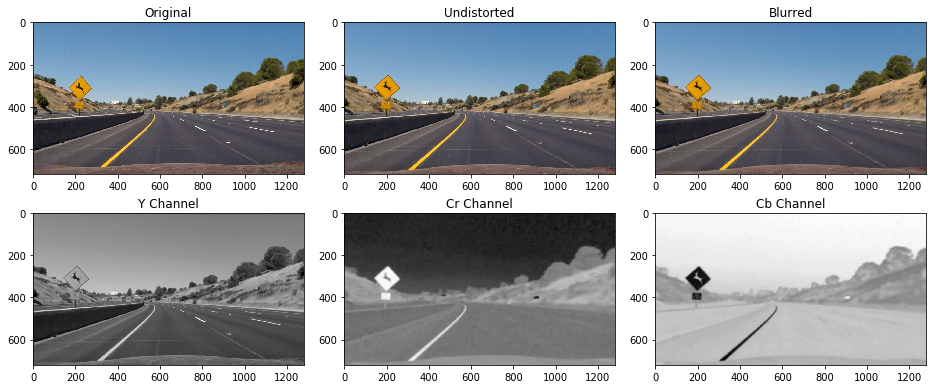

In [91]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()

img = mpimg.imread(filename)
undist = undistort(img, mtx, dist)
blurred = gaussian_blur(undist, 3)

ycrcb = cv2.cvtColor(blurred, cv2.COLOR_RGB2YCrCb)

# Color Space is RGB due to matplotlib's imread method
Y = ycrcb[:,:,0]
Cr = ycrcb[:,:,1]
Cb = ycrcb[:,:,2]

axs[0].imshow(img)
axs[1].imshow(undist)
axs[2].imshow(blurred)
axs[3].imshow(Y, cmap='gray')
axs[4].imshow(Cr, cmap='gray')
axs[5].imshow(Cb, cmap='gray')

for i, title in enumerate(['Original', 'Undistorted', 'Blurred', 'Y Channel', 'Cr Channel', 'Cb Channel']):
    axs[i].set_title(title, fontsize=12)

Based on some testing of individual images (one of which is shown above), it seems that the S Channel in HLS color space and the V Channel is HSV color space give good results for lane finding.  Let's wrap these into functions.

In [92]:
def r_threshold(img, thresh=(0,255)):
    new_img = np.copy(img)

    # Color Space is RGB due to matplotlib's imread method
    R = new_img[:,:,0]

    binary_output = np.zeros_like(R)
    binary_output[(R >= thresh[0]) & (R <= thresh[1])] = 1
    return np.copy(binary_output) 

In [93]:
def b_threshold(img, thresh=(0,255)):
    new_img = np.copy(img)
    B = new_img[:,:,2]

    binary_output = np.zeros_like(B)
    binary_output[(B >= thresh[0]) & (B <= thresh[1])] = 1
    return np.copy(binary_output) 

In [94]:
def s_threshold(img, thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]

    binary_output = np.zeros_like(S)
    binary_output[(S >= thresh[0]) & (S <= thresh[1])] = 1
    return np.copy(binary_output) 

In [95]:
def v_threshold(img, thresh=(0,255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v = hsv[:,:,2]

    binary_output = np.zeros_like(v)
    binary_output[(v >= thresh[0]) & (v <= thresh[1])] = 1
    return np.copy(binary_output) 

In [96]:
# CIELuv Space
def V_threshold(img, thresh=(0,255)):
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)
    V = luv[:,:,2]

    binary_output = np.zeros_like(V)
    binary_output[(V >= thresh[0]) & (V <= thresh[1])] = 1
    return np.copy(binary_output) 
    

### Combining Saturation (HLS) & Value (HSV) Thresholds

### Using the R Channel Only

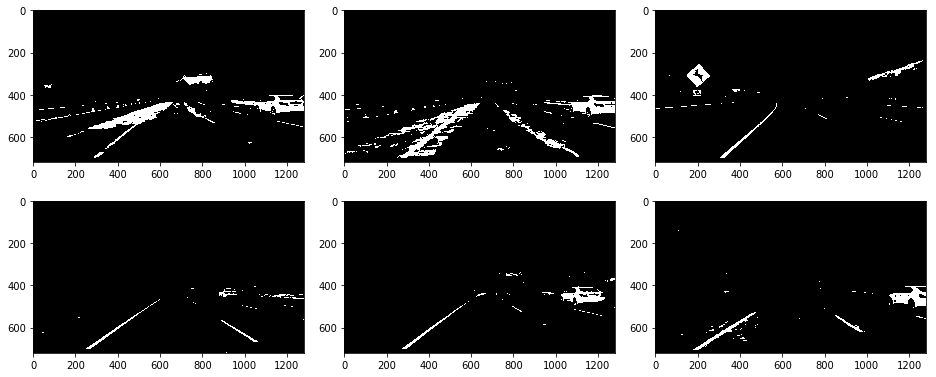

In [97]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()
files = glob.glob('test_images/test*.jpg')
#files = glob.glob('output_images/ProblemClip*.jpg')

# iterate through the images
for idx, file in enumerate(files):
    img = mpimg.imread(file)
    undist = undistort(img, mtx, dist)
    blurred = gaussian_blur(undist, 3)
    
    r_thresh = r_threshold(blurred, (200, 255))    
    axs[idx].imshow(r_thresh, cmap='gray')

#### Using the B Channel Only

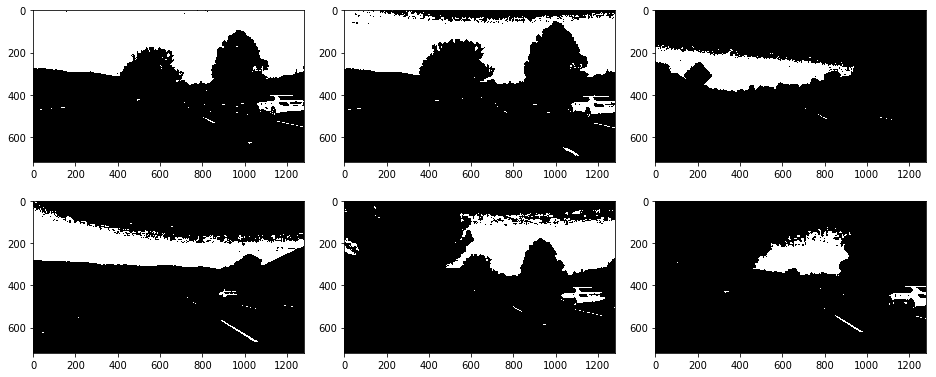

In [98]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()

# iterate through the images
for idx, file in enumerate(files):
    img = mpimg.imread(file)
    undist = undistort(img, mtx, dist)
    blurred = gaussian_blur(undist, 3)
    
    b_thresh = b_threshold(blurred, (200, 255))    
    axs[idx].imshow(b_thresh, cmap='gray')

### Using the S Channel Only

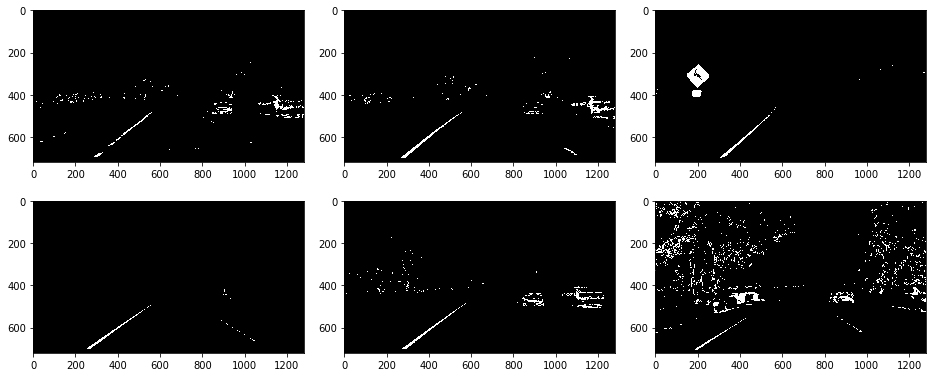

In [99]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()

# iterate through the images
for idx, file in enumerate(files):
    img = mpimg.imread(file)
    undist = undistort(img, mtx, dist)
    blurred = gaussian_blur(undist, 3)
    
    s_thresh = s_threshold(blurred, (200, 255))    
    axs[idx].imshow(s_thresh, cmap='gray')

### Using the V Channel Only - HSV Space

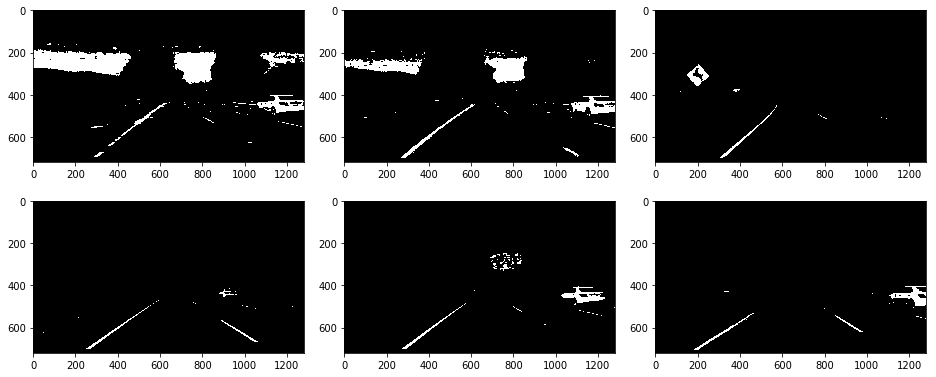

In [100]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()

# iterate through the images
for idx, file in enumerate(files):
    img = mpimg.imread(file)
    undist = undistort(img, mtx, dist)
    blurred = gaussian_blur(undist, 3)
    
    v_thresh = v_threshold(blurred, (220, 255))    
    axs[idx].imshow(v_thresh, cmap='gray')

#### Using the V Channel Only - CIELuv Space

In [101]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()

# iterate through the images
for idx, file in enumerate(files):
    img = mpimg.imread(file)
    undist = undistort(img, mtx, dist)
    blurred = gaussian_blur(undist, 3)
    
    V_thresh = V_threshold(blurred, (160, 250))    
    axs[idx].imshow(V_thresh, cmap='gray')

### R & B Channels

In [102]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()

# iterate through the images
for idx, file in enumerate(files):
    img = mpimg.imread(file)
    undist = undistort(img, mtx, dist)
    blurred = gaussian_blur(undist, 3)
    
    r_thresh = r_threshold(blurred, (200, 255))
    b_thresh = b_threshold(blurred, (200, 255))

    
    combination = ( (r_thresh == 1) & (b_thresh == 1) )
    combined = np.zeros_like(r_thresh)
    combined[combination] = 1
    
    axs[idx].imshow(combined, cmap='gray')

### Combining Color Channels

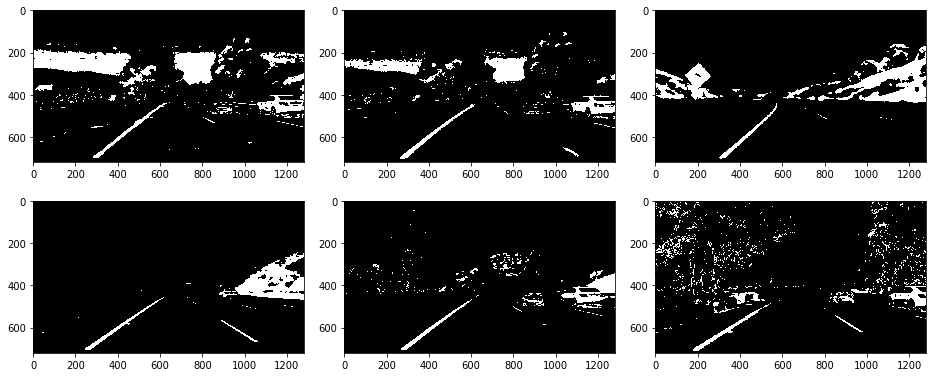

In [103]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()

# iterate through the images
for idx, file in enumerate(files):
    img = mpimg.imread(file)
    undist = undistort(img, mtx, dist)
    blurred = gaussian_blur(undist, 3)
    
    r_thresh = r_threshold(blurred, (200, 255))
    b_thresh = b_threshold(blurred, (200, 255))
    s_thresh = s_threshold(blurred, (200, 255))
    v_thresh = v_threshold(blurred, (220, 255))  
    V_thresh = V_threshold(blurred, (160, 255))  
    
    combination = ( (v_thresh == 1) | (V_thresh == 1) | ((r_thresh == 1) & (b_thresh == 1)) | (s_thresh == 1) )
    combined = np.zeros_like(s_thresh)
    combined[combination] = 1
    
    axs[idx].imshow(combined, cmap='gray')

### Putting It All Together

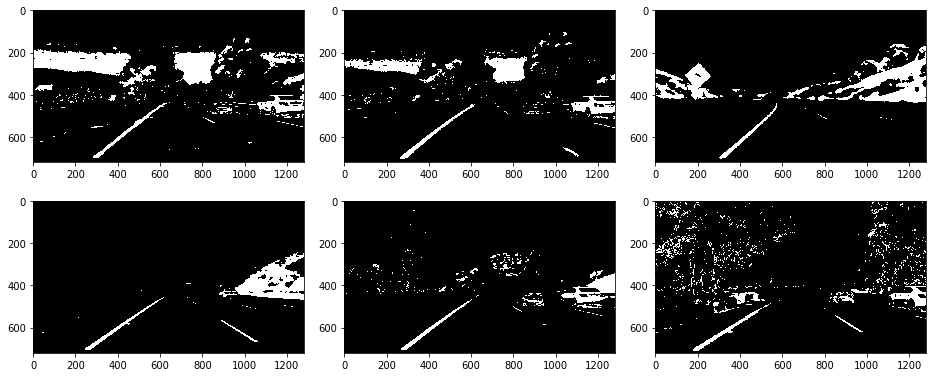

In [104]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()

# iterate through the images
for idx, file in enumerate(files):
    img = mpimg.imread(file)
    undist = undistort(img, mtx, dist)
    blurred = gaussian_blur(undist, 3)
    
    grad_x_thresh = sobel_thresh(blurred, 'x', (100, 255))
    grad_y_thresh = sobel_thresh(blurred, 'y', (100, 250))
    grad_mag_thresh = mag_thresh(blurred, 3, (100, 250))
    grad_dir_thresh = dir_thresh(blurred, 3, (0.85, 1.05))
    
    r_thresh = r_threshold(blurred, (200, 255))
    b_thresh = b_threshold(blurred, (200, 255))
    s_thresh = s_threshold(blurred, (200, 255))
    v_thresh = v_threshold(blurred, (220, 255))  
    V_thresh = V_threshold(blurred, (160, 255))  
    
    gradient_threshold = ((grad_mag_thresh == 1) & (grad_dir_thresh == 1)) | (grad_x_thresh == 1) | (grad_y_thresh == 1)
    color_threshold = ( (v_thresh == 1) | (V_thresh == 1) | ((r_thresh == 1) & (b_thresh == 1)) | (s_thresh == 1) )
    
    combination = ( color_threshold )
    combined = np.zeros_like(s_thresh)
    combined[combination] = 1
    
    axs[idx].imshow(combined, cmap='gray')

### Good strong lane markings.  Now we just need to apply a region mask.

In [105]:
# This is just copied and pasted from the first project
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [106]:
def apply_thresholds(blurred):
    # create thresholded binary images
    grad_x_thresh = sobel_thresh(blurred, 'x', (70, 255))
    
    r_thresh = r_threshold(blurred, (200, 255))   # RGB Space
    b_thresh = b_threshold(blurred, (200, 255))   # RGB Space
    s_thresh = s_threshold(blurred, (200, 255))   # HLS Space
    v_thresh = v_threshold(blurred, (220, 255))   # HSV Space
    V_thresh = V_threshold(blurred, (160, 255))   # CIELuv Space

    # combine the binary images
    gradient_threshold =  ((grad_mag_thresh == 1) & (grad_dir_thresh == 1)) | (grad_x_thresh == 1) | (grad_y_thresh == 1) 
    color_threshold = ( (v_thresh == 1) | (V_thresh == 1) | ((r_thresh == 1) & (b_thresh == 1)) | (s_thresh == 1) )
    combination = ( color_threshold )

    combined = np.zeros_like(s_thresh)
    combined[combination] = 1
    
    # apply region mask
    xsize = img.shape[1]
    ysize = img.shape[0]
    vertices = np.array([[(0,ysize), (xsize/2 -1, 380), (xsize/2 +1, 380), (xsize,ysize)]], dtype=np.int32)
    masked_img = region_of_interest(combined, vertices)
    return masked_img      

In [107]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()

# iterate through the images
for idx, file in enumerate(files):
    img = mpimg.imread(file)
    undist = undistort(img, mtx, dist)
    blurred = gaussian_blur(undist, 3)
    
    combined = apply_thresholds(blurred)
    
    axs[idx].imshow(combined, cmap='gray')

Looking good!

## Perspective Transform

In [108]:
# Perform perspective transform
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[545, 480],[735, 480],
                      [310, 640],[990, 640]])
    dst = np.float32([[310, 350], [1075, 350], 
                     [310, 640],[1075, 640]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

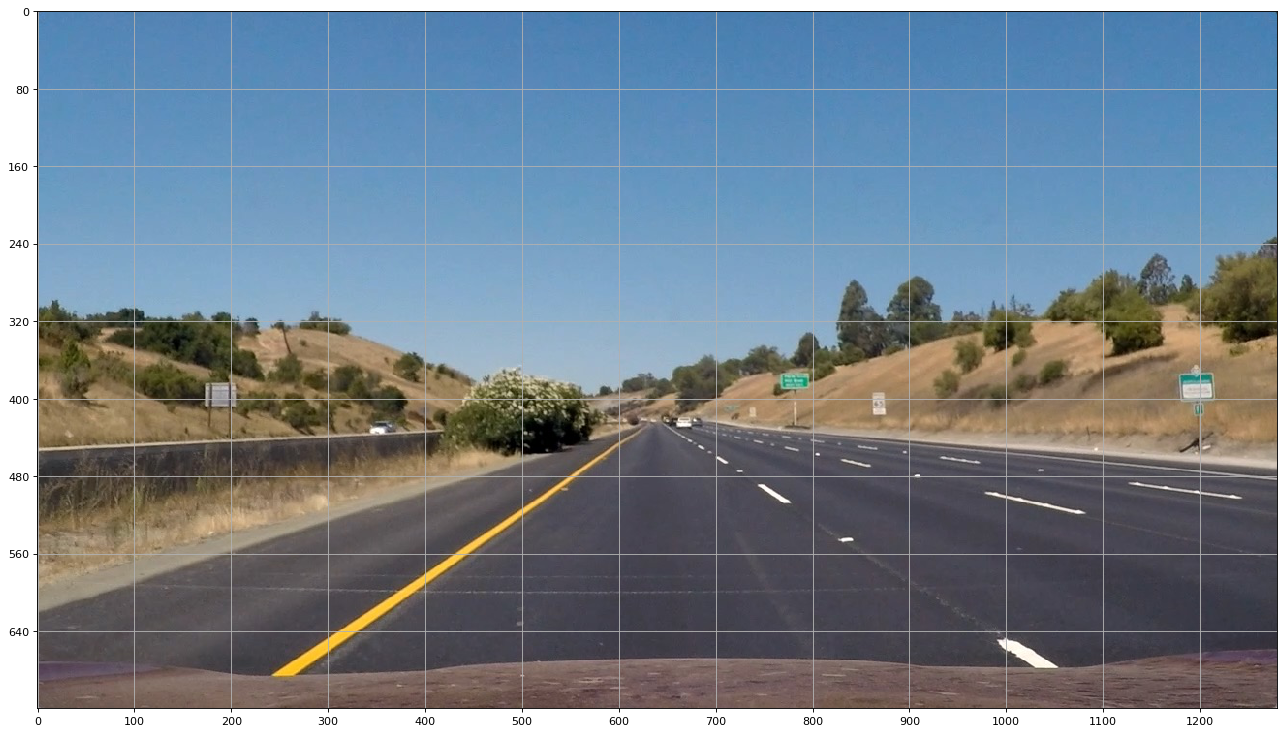

In [109]:
filename = 'test_images/straight_lines1.jpg'
img = mpimg.imread(filename)
%matplotlib inline
plt.figure(num=None, figsize=(20, 14), dpi=80, facecolor='w', edgecolor='k')
plt.xticks(np.arange(0, 1280, step=100))
plt.yticks(np.arange(0, 720, step=80))
plt.imshow(img)
plt.grid()

In [110]:
img = mpimg.imread(filename)
warped = warp(img)
plt.imshow(warped)

After a bit of tuning, the lines look pretty straight from a birds-eye view.

### Apply warping to rectify the test images

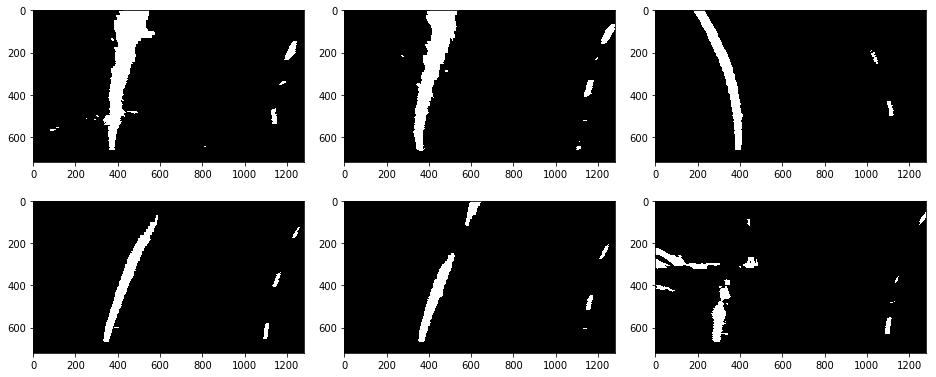

In [111]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()

# iterate through the images
for idx, file in enumerate(files):
    img = mpimg.imread(file)
    undist = undistort(img, mtx, dist)
    blurred = gaussian_blur(undist, 3)
    binary_img = apply_thresholds(blurred)
    
    birds_eye = warp(binary_img)
    
    axs[idx].imshow(birds_eye, cmap='gray')

## Curve Fit the Lane Lines

First we need to get a rough idea where the lane lines are, so we look for the bright (activated) pixels.

In [112]:
def hist(img):
    # Grab only the bottom two-thirds of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    h = img.shape[0] 
    bottom_half = img[h//2:, :]

    # Sum values across image pixels vertically
    return np.sum(bottom_half, axis=0)

In [113]:
fig, axs = plt.subplots(2,3, figsize=(16, 7))
fig.subplots_adjust(hspace = .001, wspace=.15)
axs = axs.ravel()

# iterate through the images
for idx, file in enumerate(files):
    img = mpimg.imread(file)
    undist = undistort(img, mtx, dist)
    blurred = gaussian_blur(undist, 3)
    binary_img = apply_thresholds(blurred)
    birds_eye = warp(binary_img)
    
    histogram = hist(birds_eye)

    axs[idx].plot(histogram)

We can clearly see the lane signals from the instagram.  This gives us an average position of the lines over the bottom two-thirds of the image which we will use as a starting point for our first windows below.  To have the computer find the location of the lane pixels, I will copy & paste the function I worked on in a previous project.

### Lane Pixel Finding Using Sliding Windows

In [114]:
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

In [115]:
def find_lane_pixels(binary_warped, show_windows=True):
    
    '''Using the sliding window approach'''''
    
    # Take a histogram of the bottom half of the image
    histogram = hist(binary_warped)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    window_height = np.int(binary_warped.shape[0]//nwindows)
    window_width = 80   # used for convolution method
        
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
      
        # Draw the windows on the visualization image
        if show_windows:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds])) 

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    if len(left_lane_inds) > 0:
        left_lane_inds = np.concatenate(left_lane_inds)
    if len(right_lane_inds) > 0:
        right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

The function above will return from the bird's-eye binary image, the x and y locations of the left and the right lane lines and will also return an annotated version of the image show what was detected.  The next step is to fit a curve to each the left and the right lane lines using the detected lane pixels.  Once again, I will copy & paste a function that I coded in a previous exercise.

In [116]:
def find_lane_pixels2(binary_warped, show_windows=True):
    
    '''Using the convolution method'''
    
    # Take a histogram of the bottom half of the image
    histogram = hist(binary_warped)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 80
    
    window_height = np.int(binary_warped.shape[0]//nwindows)
    window_width = 80   # used for convolution method
        
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    window_centroids = find_window_centroids(binary_warped, window_width, window_height, margin)
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        ### Find the four below boundaries of the window ###
        win_xleft_low = np.int(window_centroids[window][0]) - window_width
        win_xleft_high = np.int(window_centroids[window][0]) + window_width
        win_xright_low = np.int(window_centroids[window][1]) - window_width
        win_xright_high = np.int(window_centroids[window][1]) + window_width

        # Draw the windows on the visualization image
        if show_windows:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    if len(left_lane_inds) > 0:
        left_lane_inds = np.concatenate(left_lane_inds)
    if len(right_lane_inds) > 0:
        right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [117]:
def fit_polynomial_show_windows(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels2(binary_warped, False)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit

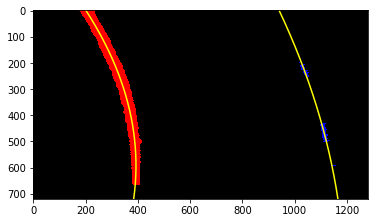

In [118]:
filename = 'test_images/test2.jpg'
#filename = 'output_images/ProblemClip3.jpg'

img = mpimg.imread(filename)
undist = undistort(img, mtx, dist)
blurred = gaussian_blur(undist, 3)
binary_img = apply_thresholds(blurred)
birds_eye = warp(binary_img)

out_img, left_fit, right_fit = fit_polynomial_show_windows(birds_eye)

plt.imshow(out_img)

### Lane Finding Method II - Search Around A Previously-Known Location

If the location of the lane is known from a previous frame, we can search around there on the basis that the location will not change appreciably between frames.

In [119]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return left_fitx, right_fitx, ploty

def search_around_poly_annotate(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 60

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

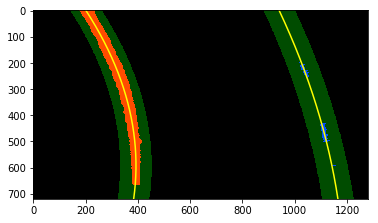

In [120]:
img = mpimg.imread(filename)
undist = undistort(img, mtx, dist)
blurred = gaussian_blur(undist, 3)
binary_img = apply_thresholds(blurred)
birds_eye = warp(binary_img)

out_img = search_around_poly_annotate(birds_eye, left_fit, right_fit)

plt.imshow(out_img)

Add a function that uses the lane life fits to return lane curvature and vehicle offset from center.

In [121]:
def curvature_and_offset(left_fit, right_fit):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = 720   # bottom of image
    
    # Calculation of R_curve (radius of curvature)
    left_curverad  = ((1 + (2*(left_fit[0]/xm_per_pix)*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*(left_fit[0]/xm_per_pix))
    right_curverad = ((1 + (2*(right_fit[0]/xm_per_pix)*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*(right_fit[0]/xm_per_pix))
    
    # find offset
    camera_center = 1280 // 2
    
    left_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    right_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    lane_center = (left_x + right_x) // 2
    
    offset = (lane_center - camera_center) * xm_per_pix
    ave_curvature = (left_curverad + right_curverad) / 2
    
    return ave_curvature, offset

In [122]:
curvature, offset = curvature_and_offset(left_fit, right_fit)
print('Lane Curvature:{:.2f}m, Offset:{:.2f}m'.format(curvature, offset))

Lane Curvature:501.44m, Offset:0.71m


At the stage we are ready to draw the detected lane boundaries onto the warped image.

In [123]:
def unwarp(img):
# Perform a reverse perspective transform
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[545, 480],[735, 480],
                      [310, 640],[990, 640]])
    dst = np.float32([[310, 350], [1075, 350], 
                     [310, 640],[1075, 640]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, Minv, img_size)
    return warped

In [124]:
def draw_lane_boundary(warped, points, leftx, lefty, rightx, righty):

    left_fitx, right_fitx, ploty = points
    center_fitx = (left_fitx + right_fitx) // 2
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    pts_center = np.array([np.transpose(np.vstack([center_fitx, ploty]))])

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Draw the centerline of the lane region
    cv2.polylines(color_warp, np.int_([pts_center]), isClosed=False, color=(255, 200, 0), thickness=10)
    
    # color the left and right lanes line red & blue respectively on the warped image
    out_img = np.dstack((warped, warped, warped))*255      # create a color version  
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    return unwarp(color_warp), out_img 

Because the above functions annotate the images ina manner that if useful for degubbing and auditing purposes, I will define new, similar functions that perform the same calculations without the overhead of the annotations.  This will make it more suitable for video image processing.

In [125]:
def add_text(img, offset, curvature):
    font = cv2.FONT_HERSHEY_DUPLEX
    h = img.shape
    
    text = 'Radius of Curvature: {:.0f}m'.format(curvature)
    cv2.putText(img, text, (40,70), font, 1.4, (255, 200, 0), 2, cv2.LINE_AA)
    
    suffix = 'left'
    if offset < 0: suffix = 'right'
    text = 'Offset: {:.2f}m {}'.format(abs(offset), suffix)
    cv2.putText(img, text, (40,130), font, 1.4, (255, 200, 0), 2, cv2.LINE_AA)
    return img

In [126]:
def annotate_image(undistorted, warped):
    
    # use sliding windows to find the initial curve fit for each lane
    leftx, lefty, rightx, righty, out_img = find_lane_pixels2(warped, False)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    fit_poly(warped.shape, leftx, lefty, rightx, righty)
    
    # if we have a curve fit, we can use then search_around_poly() function.
    # since this is just a single image and not a video stream, we will ignore this for now
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    curvature, offset = curvature_and_offset(left_fit, right_fit)
    
    points = (left_fitx, right_fitx, ploty)
    lane_img, warped = draw_lane_boundary(warped, points, leftx, lefty, rightx, righty)
    
    plt.imshow(lane_img)
    
    # Combine the result with the original image
    merged = cv2.addWeighted(undistorted, 1, lane_img, 0.3, 0) 
    
    # add the offset and curvature info
    annotated = add_text(merged, offset, curvature)
    
    return annotated

We are just about done!  All that remains to be done is to prepare this pipeline for video processing.  But first there is one small and final detail to add.  Since, in general, the lane lines vary from image to image and in some images may not be detected erroneously or not at all, I will add a Lines() class and a lines_handler() function that will be responsible for determining the best curve fit to use for each lane in each image based upon some sanity checks to ensure that the lane detection algorithm does not display erratic behavior.

In [127]:
# Define a class to receive the characteristics of each line detection
class Line():
 
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.curvature = None 
        #distance in meters of vehicle center from the line
        self.offset = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        #number of frames since last acceptable lane line detection
        self.misses = 0
        
    def add_new_line_fit(self, fit):
        self.current_fit.append(fit)
        if len(self.current_fit) > 3: self.current_fit.pop(0)  # prune the queue 
            
        # find the best fit
        if len(self.current_fit) > 0: 
            self.best_fit = np.average(self.current_fit, axis=0) 
            self.detected = True
            self.misses = 0
        else:
            self.detected = False
            self.misses += 1
            
            if self.misses > 3:
                self.best_fit = None
                self.current_fit = []
                
    def remove_oldest_fit(self):
        if len(self.current_fit):
            return self.current_fit.pop(0)
        else:
            return None

The last step is to sting together the image processing pipeling to be used to process each frame of video.  To help with this, I have modified the annotate_image() function above into the annotate_frame() function below to make suit more suitable for processing of sequential images. 

In [128]:
def search_around_poly(binary_warped, left_fit, right_fit):
    # width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

In [129]:
def annotate_frame(undistorted, warped, force_fit = False):
    left_fit = None
    right_fit = None
    leftx = None
    lefty = None
    rightx = None
    righty = None
    left_fitx = None
    right_fitx = None
    
    if not (left_line.detected and left_line.detected):   
        # search using sliding window method
        leftx, lefty, rightx, righty, out_img = find_lane_pixels2(warped, False)
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        # search near previously detected lines
        try:
            leftx, lefty, rightx, righty = search_around_poly(warped, left_line.best_fit, right_line.best_fit)
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
        except:
            print('The function failed to fit a line!')
            ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty
     
    
    # sanity check before adding new lines
    addFit = True
    if left_fit != None and right_fit != None:
        y_eval = 720
        left_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
        right_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
        
        if 700 > (right_x - left_x) > 900: addFit = False    # lane must be 600+ pixels width at the bottom of image
        #if np.sign(left_fit[0]) != np.sign(right_fit[0]): addFit = False   # Lane curvatures must be in same direction
        
        if addFit:
            left_line.add_new_line_fit(left_fit)
            right_line.add_new_line_fit(right_fit) 

            
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        if (left_line.detected and right_line.detected) or force_fit:
            left_fitx = left_line.best_fit[0]*ploty**2 + left_line.best_fit[1]*ploty + left_line.best_fit[2]
            right_fitx = right_line.best_fit[0]*ploty**2 + right_line.best_fit[1]*ploty + right_line.best_fit[2]
    except TypeError:
    # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    points = (left_fitx, right_fitx, ploty)
    if left_line.best_fit != None and right_line.best_fit != None:
        lane_img, warped_painted = draw_lane_boundary(warped, points, leftx, lefty, rightx, righty)
        curvature, offset = curvature_and_offset(left_line.best_fit, right_line.best_fit)
        # Combine the lane image with the undistorted image
        merged = cv2.addWeighted(undistorted, 1.0, lane_img, 0.3, 0)
        annotated = add_text(merged, offset, curvature)
        return annotated, warped_painted
    else:
        return undistorted, warped

### Image Processing Step-By-Step

In [130]:
def add_image_insert(img):  
    
    # found this snippet online
    
    # insert graphic overlay map
    graphic_bkg = np.zeros_like(result)
    # scale the graphic measure that we generated near the start for finding window centers, by some constant factor in both axis
    g_scale = 0.4
    graphic_overlay = cv2.resize(graphic_measure, (0,0), fx=g_scale, fy=g_scale) 
    g_xoffset = result.shape[1]-graphic_overlay.shape[1]
    # overlay the graphic measure in the result image at the top right corner
    img[:graphic_overlay.shape[0], g_xoffset:g_xoffset+graphic_overlay.shape[1]] = graphic_overlay

    return img

After each step, save the image for the report.

In [132]:
filename = 'test2'
left_line = Line()
right_line = Line()
img = mpimg.imread('test_images/{}.jpg'.format(filename))
img_copy = np.copy(img)
output_file = 'output_images/{}.jpg'.format(filename)
plt.imsave(output_file, img_copy)

undistorted = undistort(img_copy, mtx, dist)
output_file = 'output_images/{}_undistorted.jpg'.format(filename)
plt.imsave(output_file, undistorted)

blurred = gaussian_blur(undistorted, 3)
output_file = 'output_images/{}_blurred.jpg'.format(filename)
plt.imsave(output_file, blurred)

binary_img = apply_thresholds(blurred)
output_file = 'output_images/{}_binary.jpg'.format(filename)
plt.imsave(output_file, binary_img,  cmap = 'gray')

birds_eye = warp(binary_img)
output_file = 'output_images/{}_warped.jpg'.format(filename)
plt.imsave(output_file, birds_eye,  cmap = 'gray')

final_img, warped_painted = annotate_frame(undistorted, birds_eye, True)
output_file = 'output_images/{}_annotated.jpg'.format(filename)
plt.imsave(output_file, final_img)

plt.imshow(final_img)

In [133]:
def process_image(img):
    img_copy = np.copy(img)
    undistorted = undistort(img_copy, mtx, dist)
    blurred = gaussian_blur(undistorted, 3)
    binary_img = apply_thresholds(blurred)
    birds_eye = warp(binary_img)
    final_img, warped_painted = annotate_frame(undistorted, birds_eye)
    return final_img

In [64]:
left_line = Line()
right_line = Line()
video_output = 'project_video_result.mp4'
project_video = VideoFileClip("project_video.mp4")#.subclip(0,5)
output_video = project_video.fl_image(process_image) 
output_video.write_videofile(video_output, audio=False)


[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [06:09<00:00,  3.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 



In [134]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('project_video_result.mp4'))

### Let's test it on the Challenge Video

In [66]:
left_line = Line()
right_line = Line()

video_output = 'challenge_video_output.mp4'
project_video = VideoFileClip("challenge_video.mp4").subclip(0,15)
output_video = project_video.fl_image(process_image) 
output_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


  2%|▏         | 7/450 [00:01<01:34,  4.70it/s]

The function failed to fit a line!
The function failed to fit a line!


  2%|▏         | 9/450 [00:01<01:32,  4.78it/s]

The function failed to fit a line!
The function failed to fit a line!


  2%|▏         | 11/450 [00:02<01:31,  4.81it/s]

The function failed to fit a line!


  3%|▎         | 12/450 [00:02<01:30,  4.84it/s]

The function failed to fit a line!


  3%|▎         | 13/450 [00:02<01:30,  4.83it/s]

The function failed to fit a line!


  3%|▎         | 14/450 [00:02<01:30,  4.82it/s]

The function failed to fit a line!


  3%|▎         | 15/450 [00:03<01:29,  4.85it/s]

The function failed to fit a line!


 30%|██▉       | 134/450 [00:35<01:29,  3.52it/s]

The function failed to fit a line!


 30%|███       | 135/450 [00:36<01:32,  3.39it/s]

The function failed to fit a line!


 30%|███       | 136/450 [00:36<01:30,  3.49it/s]

The function failed to fit a line!


 30%|███       | 137/450 [00:36<01:33,  3.36it/s]

The function failed to fit a line!


 31%|███       | 138/450 [00:36<01:29,  3.48it/s]

The function failed to fit a line!


 31%|███       | 139/450 [00:37<01:32,  3.38it/s]

The function failed to fit a line!


 31%|███       | 140/450 [00:37<01:29,  3.45it/s]

The function failed to fit a line!


 31%|███▏      | 141/450 [00:37<01:31,  3.37it/s]

The function failed to fit a line!


 32%|███▏      | 142/450 [00:38<01:27,  3.50it/s]

The function failed to fit a line!


 32%|███▏      | 143/450 [00:38<01:30,  3.39it/s]

The function failed to fit a line!


 32%|███▏      | 144/450 [00:38<01:27,  3.49it/s]

The function failed to fit a line!


 32%|███▏      | 145/450 [00:38<01:30,  3.37it/s]

The function failed to fit a line!


 32%|███▏      | 146/450 [00:39<01:28,  3.44it/s]

The function failed to fit a line!


 33%|███▎      | 147/450 [00:39<01:30,  3.34it/s]

The function failed to fit a line!


 33%|███▎      | 148/450 [00:39<01:27,  3.46it/s]

The function failed to fit a line!


 33%|███▎      | 149/450 [00:40<01:30,  3.31it/s]

The function failed to fit a line!


 33%|███▎      | 150/450 [00:40<01:28,  3.40it/s]

The function failed to fit a line!


100%|██████████| 450/450 [02:07<00:00,  3.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 



In [135]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">''
</video>
""".format('challenge_video_output.mp4'))

### Test it on the Harder Challenge Video

In [68]:
left_line = Line()
right_line = Line()
video_output = 'harder_challenge_video_output.mp4'
project_video = VideoFileClip("harder_challenge_video.mp4")#.subclip(0,2)
output_video = project_video.fl_image(process_image) 
output_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


 16%|█▌        | 190/1200 [01:00<05:21,  3.14it/s]

The function failed to fit a line!


 16%|█▌        | 191/1200 [01:00<05:25,  3.10it/s]

The function failed to fit a line!


 16%|█▌        | 192/1200 [01:00<05:07,  3.28it/s]

The function failed to fit a line!


 16%|█▌        | 193/1200 [01:01<05:22,  3.12it/s]

The function failed to fit a line!


 16%|█▌        | 194/1200 [01:01<05:07,  3.27it/s]

The function failed to fit a line!


 16%|█▋        | 195/1200 [01:01<05:13,  3.20it/s]

The function failed to fit a line!


 16%|█▋        | 197/1200 [01:02<05:16,  3.17it/s]

The function failed to fit a line!


 16%|█▋        | 198/1200 [01:02<05:06,  3.27it/s]

The function failed to fit a line!


 17%|█▋        | 199/1200 [01:03<05:18,  3.14it/s]

The function failed to fit a line!


 17%|█▋        | 200/1200 [01:03<05:10,  3.22it/s]

The function failed to fit a line!


 17%|█▋        | 201/1200 [01:03<05:22,  3.10it/s]

The function failed to fit a line!


 17%|█▋        | 202/1200 [01:04<05:13,  3.19it/s]

The function failed to fit a line!


 17%|█▋        | 203/1200 [01:04<05:30,  3.02it/s]

The function failed to fit a line!


 17%|█▋        | 204/1200 [01:04<05:22,  3.08it/s]

The function failed to fit a line!


 59%|█████▉    | 705/1200 [04:04<02:47,  2.96it/s]

The function failed to fit a line!


 59%|█████▉    | 710/1200 [04:05<02:44,  2.97it/s]

The function failed to fit a line!


 60%|█████▉    | 716/1200 [04:08<02:58,  2.71it/s]

The function failed to fit a line!


 60%|█████▉    | 718/1200 [04:08<02:33,  3.13it/s]

The function failed to fit a line!


 77%|███████▋  | 922/1200 [05:22<01:37,  2.86it/s]

The function failed to fit a line!


100%|█████████▉| 1199/1200 [06:55<00:00,  2.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 



In [136]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('harder_challenge_video_output.mp4'))